# Step 1: Calibration of camera intrinsic values

In [1]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
from itertools import count

In [2]:
CAMERA_ID = 'david'
CHESSBOARD_SQUARE_LENGTH_MM = 1
CHESSBOARD_DIMENSIONS = (9,6)
CAPTURE_DEVICE = 0
EXTRINSIC_CALIBRATION_FRAME_COUNT = 120


## Chessboard calibration (intrisinc parameters)

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
sample_object_points = np.zeros((CHESSBOARD_DIMENSIONS[0] * CHESSBOARD_DIMENSIONS[1],3), np.float32)

# TODO: check if this is the correct way to adjust the sizes. Used this accordint to: https://stackoverflow.com/questions/37310210/camera-calibration-with-opencv-how-to-adjust-chessboard-square-size
sample_object_points[:,:2] = np.mgrid[0:CHESSBOARD_DIMENSIONS[0],0:CHESSBOARD_DIMENSIONS[1]].T.reshape(-1,2) * CHESSBOARD_SQUARE_LENGTH_MM

# Swap axis so that the z axis is perpendicular to the chessboard
sample_object_points[:, [1, 0]] = sample_object_points[:, [0, 1]]

# Arrays to store object points and image points from all the images.
object_points = [] # 3d point in real world space
image_points = [] # 2d points in image plane.

images = glob.glob(f'data/calibration/{CAMERA_ID}/*.png')
print(f'Found {len(images)} calibration images')

for fname in images:
    image = cv2.imread(fname)
    grayscale_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayscale_image, CHESSBOARD_DIMENSIONS, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        object_points.append(sample_object_points)

        improved_corners = cv2.cornerSubPix(grayscale_image, corners, (11,11), (-1,-1), criteria)
        image_points.append(improved_corners)
    else:
        print(f'Could not find chessboard corners in image {fname}')


Found 24 calibration images
Could not find chessboard corners in image data/calibration/david/calibration_frame_2021-04-10 15:18:54.712130.png
Could not find chessboard corners in image data/calibration/david/calibration_frame_2021-04-02 16:39:56.783532.png
Could not find chessboard corners in image data/calibration/david/calibration_frame_2021-04-10 15:18:39.623633.png
Could not find chessboard corners in image data/calibration/david/calibration_frame_2021-04-02 16:39:36.784381.png
Could not find chessboard corners in image data/calibration/david/calibration_frame_2021-04-10 15:18:44.712054.png
Could not find chessboard corners in image data/calibration/david/calibration_frame_2021-04-02 16:38:46.784388.png
Could not find chessboard corners in image data/calibration/david/calibration_frame_2021-04-10 15:18:49.714146.png
Could not find chessboard corners in image data/calibration/david/calibration_frame_2021-04-10 15:18:59.711540.png
Could not find chessboard corners in image data/cali

### Intrinsic Parameters

In [4]:
ret, intrinsic_matrix, distortion_coefs, rotation_vecs, translation_vecs = cv2.calibrateCamera(object_points, image_points, grayscale_image.shape[::-1],None,None)
print('Image Dimensions')
print(grayscale_image.shape)
print('Intrinsic Matrix')
print(intrinsic_matrix)
print('Distortion Coefficients')
print(distortion_coefs)
print('Rotation Vectors')
print(rotation_vecs)
print('Translation Vectors')
print(translation_vecs)

Image Dimensions
(480, 640)
Intrinsic Matrix
[[563.75694837   0.         332.16377869]
 [  0.         558.41973892 215.1414695 ]
 [  0.           0.           1.        ]]
Distortion Coefficients
[[ 0.22044414 -0.71477837 -0.00554924 -0.00207883  0.98609804]]
Rotation Vectors
[array([[-2.21650946],
       [-2.05585281],
       [ 0.20860675]]), array([[ 0.1862303 ],
       [-2.96650025],
       [ 0.03416103]]), array([[ 1.11185453],
       [-2.75652626],
       [-0.09634553]]), array([[ 0.57000195],
       [-2.91079404],
       [-0.03637475]]), array([[ 1.48355727],
       [-2.58056638],
       [-0.13644684]]), array([[ 1.2813226 ],
       [-2.70197538],
       [-0.06340513]]), array([[ 2.10659329],
       [-2.12234605],
       [-0.18750236]]), array([[ 2.12104354],
       [-2.08528642],
       [-0.19283236]]), array([[-3.06576162],
       [-0.61681721],
       [ 0.25183365]]), array([[ 2.12594301],
       [-1.88991496],
       [-0.23549814]]), array([[ 2.13261022],
       [-2.1133617 ]

### Intrinsic Reprojection Error

In [5]:
def calculate_reprojection_error(objpoints, imgpoints, rvecs, tvecs, imatrix, distortion):
    mean_error = 0
    for i in range(len(objpoints)):
        calculted_image_points, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], imatrix, distortion)
        error = cv2.norm(imgpoints[i], calculted_image_points, cv2.NORM_L2)/len(calculted_image_points)
        mean_error += error

    return mean_error/len(objpoints)

In [6]:
print(f'Reprojection error: {calculate_reprojection_error(object_points, image_points, rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)}')

Reprojection error: 0.0305571624980066


## Chessboard calibration (extrinsic parameters)

In [7]:
captureDevice = cv2.VideoCapture(CAPTURE_DEVICE)

'''
EXTRINSIC PARAMETERS
'''

# Arrays to store object points and image points from all the images.
object_points = [] # 3d point in real world space
image_points = [] # 2d points in image plane.

for _ in range(EXTRINSIC_CALIBRATION_FRAME_COUNT):
    ret, image = captureDevice.read()
    grayscale_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayscale_image, CHESSBOARD_DIMENSIONS, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        object_points.extend(list(sample_object_points))
        improved_corners = cv2.cornerSubPix(grayscale_image, corners, (11,11), (-1,-1), criteria)
        image_points.extend(list(improved_corners))
    else:
        print(f'Could not find chessboard corners in image')

object_points = np.float64(object_points)
image_points = np.float64(image_points)
print(object_points.shape)
print(image_points.shape)
  

(6480, 3)
(6480, 1, 2)


In [8]:
ret, rotation_vecs, translation_vecs, _ = cv2.solvePnPRansac(object_points, image_points, intrinsic_matrix, distortion_coefs)

### Extrinsic Reprojection Error

In [9]:
mean_error = 0

for i in range(len(object_points)):
    calulated_image_points, _ = cv2.projectPoints(object_points[i], rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)
    # print(image_points[i])
    # print(calulated_image_points)
    error = cv2.norm(image_points[i],calulated_image_points[0], cv2.NORM_L2)/len(calulated_image_points)
    mean_error += error

print(f'Reprojection error: {mean_error/len(object_points)}')

Reprojection error: 0.4273968363979462


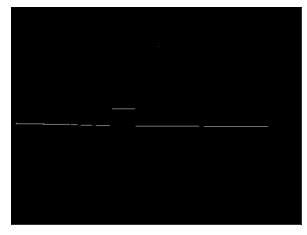

In [10]:
shadow_points = cv2.imread('data/result_200_200_5_8.png')
plt.xticks([]), plt.yticks([])
plt.imshow(shadow_points)

In [11]:
rotation_matrix = cv2.Rodrigues(rotation_vecs)[0]
extrinsic_matrix = np.concatenate((rotation_matrix, translation_vecs), axis=1)
perspective_projection_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)
perspective_projection_matrix

array([[-2.56721431e+02,  5.76494172e+02, -1.72925560e+02,
         5.68977512e+03],
       [ 1.54234464e+02,  1.92983875e+01, -5.77890785e+02,
         6.39472161e+03],
       [-8.08743686e-01,  4.00169007e-02, -5.86798346e-01,
         2.44152137e+01]])

In [12]:

def get_y_z_coord(i, j, ppm):
    k1 = ppm[2] * i
    k2 = ppm[2] * j
    k3 = k1 - ppm[0]
    k4 = k2 - ppm[1]
    a = [k3[1:3], k4[1:3]]
    b = [-k3[3], -k4[3]]

    res = np.linalg.solve(a, b)

    return (res[0], res[1])

In [13]:
get_y_z_coord(1,1, perspective_projection_matrix)

(-6.594779631111602, 10.814582673495737)

In [16]:

points_y = []
points_z = []
print(shadow_points.shape)
for j in range(shadow_points.shape[0]):
    for i in range(shadow_points.shape[1]):

        if(shadow_points[j][i][0] == 255):
            y, z = get_y_z_coord(i,j, perspective_projection_matrix)

            #if abs(z) < 5:
            points_y.append(y)
            points_z.append(z)

(480, 640, 3)


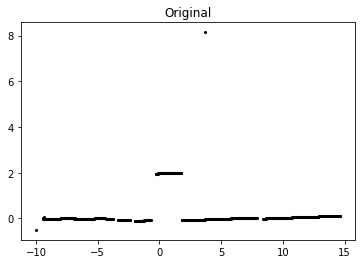

In [17]:
figure, subplots = plt.subplots(1)
points = []
subplots.set_title('Original')
subplots.scatter(points_y, points_z, color='black', marker='.', linewidths=0.1)
plt.show()